In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.patches as mpatches


SIMPLIFIED Target coefficient diagnostics:
Number of basis functions: 9
φ_k values: [ 1.          0.37571823 -0.95203023  0.1148112   0.07514189]
λ_k values: [0.         0.5        0.2        0.5        0.33333333]

Starting IMPROVED iLQR with exploration...

Initial validation:
Target vs Current coefficients:
  k=[0 0]: φ_k=1.0000, c_k=1.0000, diff=-0.0000
  k=[0 1]: φ_k=0.3757, c_k=1.1756, diff=0.7999
  k=[0 2]: φ_k=-0.9520, c_k=-0.6180, diff=0.3340
  k=[1 0]: φ_k=0.1148, c_k=1.1756, diff=1.0608
  k=[1 1]: φ_k=0.0751, c_k=0.6910, diff=0.6158
  k=[1 2]: φ_k=-0.1758, c_k=-0.3633, diff=-0.1875
  k=[2 0]: φ_k=-1.1135, c_k=-0.6180, diff=0.4955
  k=[2 1]: φ_k=-0.0177, c_k=-0.3633, diff=-0.3456
  k=[2 2]: φ_k=0.6674, c_k=0.1910, diff=-0.4764

Weighted ergodic error: 1.131300

Iter 00: Cost=-41.48, ErgError=1.1313, Mu=1.00e-04
  Line search failed.
Iter 01: Cost=-41.48, ErgError=1.1313, Mu=5.00e-04
    Ergodic: 1088.96, Control: 29763.86, State: 0.01, Bound: 0.00, Explore: -3.09
  Line searc

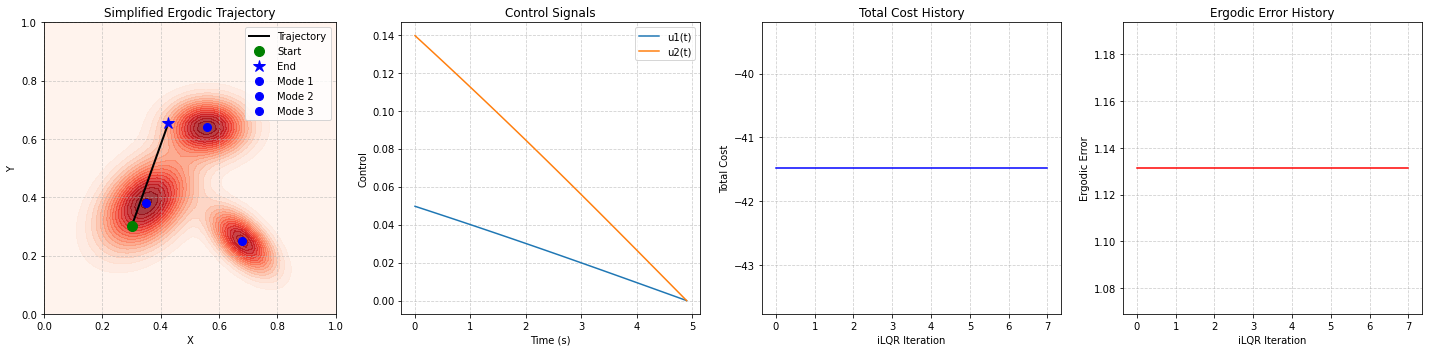


Final control statistics:
u1 range: [0.000, 0.050]
u2 range: [0.000, 0.140]
Max |u|: 0.140


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

# --- 1. GMM Parameters and Function ---
w = [0.5, 0.2, 0.3]
mu = [np.array([0.35, 0.38]), np.array([0.68, 0.25]), np.array([0.56, 0.64])]
Sigma = [
    np.array([[0.01, 0.004], [0.004, 0.01]]),
    np.array([[0.005, -0.003], [-0.003, 0.005]]),
    np.array([[0.008, 0.0], [0.0, 0.004]])
]
gaussians = [multivariate_normal(mean=m, cov=s) for m, s in zip(mu, Sigma)]

def gmm_pdf(x):
    if x.ndim == 1:
        x = x.reshape(1, -1)
    pdf_val = 0
    for weight, gauss in zip(w, gaussians):
        pdf_val += weight * gauss.pdf(x)
    return pdf_val

# --- 2. VERY Simple Fourier Basis ---
L = 1.0
N_basis = 3

def get_k_vectors(N_basis, dim=2):
    k_vectors = []
    for i in range(N_basis):
        for j in range(N_basis):
            k_vectors.append(np.array([i, j]))
    return np.array(k_vectors)

k_vectors = get_k_vectors(N_basis)
num_k = len(k_vectors)

def F_k(x, k_vec):
    """Simple cosine basis"""
    if k_vec[0] == 0 and k_vec[1] == 0:
        return 1.0
    else:
        return np.prod(np.cos(np.pi * k_vec * x / L))

# Calculate target coefficients
grid_size = 50
x_vals = np.linspace(0, L, grid_size)
y_vals = np.linspace(0, L, grid_size)
xx, yy = np.meshgrid(x_vals, y_vals)
grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
pdf_values = gmm_pdf(grid_points)
dA = (L / (grid_size - 1))**2

# Normalize PDF
pdf_integral = np.sum(pdf_values) * dA
pdf_values_normalized = pdf_values / pdf_integral

phi_k = np.zeros(num_k)
for i, k in enumerate(k_vectors):
    F_k_vals = np.array([F_k(pt, k) for pt in grid_points])
    phi_k[i] = np.sum(pdf_values_normalized * F_k_vals) * dA

# Simple spectral decay
lambda_k = np.ones(num_k)
for i, k in enumerate(k_vectors):
    k_norm_sq = np.sum(k**2)
    if k_norm_sq == 0:
        lambda_k[i] = 0
    else:
        lambda_k[i] = 1.0 / (1.0 + k_norm_sq)

print("Direct Optimization Setup:")
print(f"Basis functions: {num_k}")
print(f"Target coefficients φ_k: {phi_k[:5]}")
print()

# --- 3. Direct Trajectory Optimization ---
dt = 0.1
T_horizon = 5.0
tlist = np.arange(0, T_horizon, dt)
N_steps = len(tlist)
x0 = np.array([0.3, 0.3])

def trajectory_from_controls(u_flat):
    """Convert flat control vector to trajectory"""
    u_traj = u_flat.reshape(N_steps, 2)
    x_traj = np.zeros((N_steps + 1, 2))
    x_traj[0] = x0.copy()
    
    for t in range(N_steps):
        x_next = x_traj[t] + dt * u_traj[t]
        x_traj[t+1] = np.clip(x_next, 0, L)  # Keep in bounds
    
    return x_traj, u_traj

def calculate_ck_simple(x_traj):
    """Calculate trajectory coefficients"""
    ck = np.zeros(num_k)
    N = x_traj.shape[0] - 1  # Exclude final state
    
    for t in range(N):
        xt = x_traj[t]
        for i, k in enumerate(k_vectors):
            ck[i] += F_k(xt, k)
    
    return ck / N

def ergodic_objective(u_flat):
    """Direct ergodic optimization objective"""
    x_traj, u_traj = trajectory_from_controls(u_flat)
    
    # Ergodic cost
    ck = calculate_ck_simple(x_traj)
    erg_diff = ck - phi_k
    erg_cost = np.sum(lambda_k * erg_diff**2)
    
    # Control regularization
    ctrl_cost = 0.1 * np.sum(u_traj**2) * dt
    
    # Smoothness penalty (reduce jerkiness)
    smooth_cost = 0.01 * np.sum(np.diff(u_traj, axis=0)**2)
    
    # Exploration bonus - reward visiting distribution
    explore_cost = 0.0
    for t in range(x_traj.shape[0] - 1):
        xt = x_traj[t]
        pdf_val = gmm_pdf(xt)
        explore_cost -= 2.0 * pdf_val * dt  # Negative = reward
    
    total_cost = erg_cost + ctrl_cost + smooth_cost + explore_cost
    
    return total_cost

def ergodic_gradient(u_flat):
    """Numerical gradient for optimization"""
    grad = np.zeros_like(u_flat)
    eps = 1e-6
    
    f0 = ergodic_objective(u_flat)
    
    for i in range(len(u_flat)):
        u_plus = u_flat.copy()
        u_plus[i] += eps
        f_plus = ergodic_objective(u_plus)
        grad[i] = (f_plus - f0) / eps
    
    return grad

# --- 4. Optimization ---
print("Starting direct trajectory optimization...")

# Initialize with small random controls
np.random.seed(42)
u_init = 0.1 * np.random.randn(N_steps * 2)

# Control bounds to keep reasonable
bounds = [(-2.0, 2.0) for _ in range(N_steps * 2)]

# Run optimization
result = minimize(
    ergodic_objective,
    u_init,
    method='L-BFGS-B',
    jac=ergodic_gradient,
    bounds=bounds,
    options={'maxiter': 100, 'disp': True}
)

print(f"Optimization completed. Success: {result.success}")
print(f"Final cost: {result.fun:.4f}")
print(f"Iterations: {result.nit}")

# --- 5. Extract Results ---
u_opt = result.x
x_final_traj, u_final_traj = trajectory_from_controls(u_opt)

# Calculate final ergodic performance
ck_final = calculate_ck_simple(x_final_traj)
erg_error_final = np.sum(lambda_k * (ck_final - phi_k)**2)

print("\nFinal Results:")
print("Target vs Final coefficients:")
for i, (k, phi, c) in enumerate(zip(k_vectors, phi_k, ck_final)):
    print(f"  k={k}: φ_k={phi:.4f}, c_k={c:.4f}, diff={c-phi:.4f}")
print(f"\nFinal ergodic error: {erg_error_final:.6f}")

# --- 6. Visualization ---
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Trajectory plot
ax1 = axes[0]
pdf_plot = pdf_values.reshape(xx.shape)
contour = ax1.contourf(xx, yy, pdf_plot, levels=20, cmap='Reds', alpha=0.8)
ax1.plot(x_final_traj[:, 0], x_final_traj[:, 1], 'k-', lw=2, label='Trajectory')
ax1.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
ax1.plot(x_final_traj[-1, 0], x_final_traj[-1, 1], 'b*', markersize=12, label='End')

# Plot Gaussian centers
for i, mean in enumerate(mu):
    ax1.plot(mean[0], mean[1], 'bo', markersize=8, label=f'Mode {i+1}')

ax1.set_title('Direct Ergodic Optimization')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_xlim(0, L)
ax1.set_ylim(0, L)
ax1.set_aspect('equal')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Control signals
ax2 = axes[1]
ax2.plot(tlist, u_final_traj[:, 0], 'b-', lw=1.5, label='u1(t)')
ax2.plot(tlist, u_final_traj[:, 1], 'r-', lw=1.5, label='u2(t)')
ax2.set_title('Control Signals')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Control')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Trajectory density vs target
ax3 = axes[2]
time_bins = np.linspace(0, L, 20)
x_hist, _ = np.histogram(x_final_traj[:-1, 0], bins=time_bins, density=True)
target_hist, _ = np.histogram(grid_points[:, 0], bins=time_bins, weights=pdf_values_normalized, density=True)

bin_centers = (time_bins[:-1] + time_bins[1:]) / 2
ax3.plot(bin_centers, x_hist, 'b-', lw=2, label='Trajectory X density')
ax3.plot(bin_centers, target_hist, 'r--', lw=2, label='Target X density')
ax3.set_title('X-direction Density Comparison')
ax3.set_xlabel('X')
ax3.set_ylabel('Density')
ax3.legend()
ax3.grid(True, alpha=0.3)

# PDF values along trajectory
ax4 = axes[3]
pdf_along_traj = []
for t in range(x_final_traj.shape[0] - 1):
    pdf_val = gmm_pdf(x_final_traj[t])
    pdf_along_traj.append(pdf_val)

ax4.plot(tlist, pdf_along_traj, 'g-', lw=2)
ax4.set_title('PDF Value Along Trajectory')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('PDF Value')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final statistics
print(f"\nControl statistics:")
print(f"u1 range: [{np.min(u_final_traj[:, 0]):.3f}, {np.max(u_final_traj[:, 0]):.3f}]")
print(f"u2 range: [{np.min(u_final_traj[:, 1]):.3f}, {np.max(u_final_traj[:, 1]):.3f}]")
print(f"Max |u|: {np.max(np.abs(u_final_traj)):.3f}")

# Average PDF value (higher = better coverage of distribution)
avg_pdf = np.mean(pdf_along_traj)
print(f"Average PDF along trajectory: {avg_pdf:.6f}")